1ere étape : installons lime et shap. Rien de compliqué !

        pip install shap
        pip install lime

2eme étape : prenons différents modèles à expliquer.
- un modèle de simple sur IRIS (valeurs numérique, classification du type de plante)
- différents models de NLP (transformer sur de l'analyse de sentiments)


In [ ]:
import numpy as np
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
class_names = ['positive','negative', 'neutral']

def predictor(texts):
    outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
    probas = F.softmax(outputs.logits).detach().numpy()
    return probas

In [7]:
import transformers
import shap

# load a transformers pipeline model
model_2 = transformers.pipeline('sentiment-analysis', return_all_scores=True)

model_2(["What a great movie! ...if you have no taste."])

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

[[{'label': 'NEGATIVE', 'score': 0.0001473494921810925},
  {'label': 'POSITIVE', 'score': 0.9998526573181152}]]

In [29]:
sample_text = ["Bordeaux would be beautiful if it wasn't raining"]

In [18]:
import sklearn
from sklearn.model_selection import train_test_split
# train a SVM classifier


iris = sklearn.datasets.load_iris()

X_train,X_test,Y_train,Y_test = sklearn.model_selection.train_test_split(iris.data, iris.target, train_size=0.80)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)

SVC(probability=True)

# Avec Lime

### Sur des données textes

- L'explainer dépend du type de donnée :

In [73]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [115]:
str_to_predict = "surprising increase in revenue in spite of decrease in market share"
exp = explainer.explain_instance(str_to_predict, predictor, num_features=20, num_samples=2000)

array([[1.47349143e-04, 9.99852657e-01]])

- essayons de comprendre ce que nous retourne LIME

In [12]:
exp.as_list()

[('decrease', 0.2728214056236165),
 ('increase', -0.1767951879215601),
 ('share', 0.14186258563476822),
 ('market', 0.12410821490995712),
 ('in', -0.12343932850891079),
 ('of', -0.10927450598943578),
 ('revenue', -0.03243430595689222),
 ('surprising', -0.02563063252554813),
 ('spite', -0.009921803372397703)]

In [3]:
exp.show_in_notebook(text=str_to_predict)

- non interactif
- clair, notamment la partie phrase
- montre les limites des scores mots pour mots pour le NLP
- il n'y a pas d'autres graphes disponibles pour la partie NLP (à ma connaissance)

### Sur des données tabulées

In [19]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=iris.feature_names, class_names=iris.target_names, discretize_continuous=True)

In [22]:
exp = explainer.explain_instance(X_test[0], svm.predict_proba, num_features=2, top_labels=1)

In [27]:
exp.show_in_notebook(show_table=True, show_all=False)

# Avec Shap

- attention : shape encode des valeurs contribuant positivement en rouge et negativement en bleu

In [35]:
# explain the model
explainer = shap.Explainer(model_2) 
shap_values = explainer(sample_text)

qu'y a-t-il dans l'objet shap_values retourné par l'explainer sur notre exemple ?

In [39]:
print(shap_values)

.values =
array([[[-1.08087478e-07,  3.52819585e-08],
        [-7.55614869e-01,  7.55615595e-01],
        [-7.55614869e-01,  7.55615595e-01],
        [-2.49233702e+00,  2.49233701e+00],
        [-2.49233702e+00,  2.49233701e+00],
        [ 9.92323651e-01, -9.92322540e-01],
        [ 9.92323651e-01, -9.92322540e-01],
        [-4.40145688e-01,  4.40146658e-01],
        [-4.40145688e-01,  4.40146658e-01],
        [-4.40145688e-01,  4.40146658e-01],
        [-4.40145688e-01,  4.40146658e-01],
        [-2.16174957e-07, -7.05639170e-08]]])

.base_values =
array([[ 0.83327429, -0.83327443]])

.data =
array([['', 'Bordeaux ', 'would ', 'be ', 'beautiful ', 'if ', 'it ',
        'wasn', "'", 't ', 'raining', '']], dtype='<U10')


- un tableau avec la liste des mots (.data), les participations correspondantes de chaque mot pour chacune des classes (.values) et les valeurs totales de chaque classe (base_values)

- shap offre de nombreux graphes de visualisation
- certaines sont interactives !

In [40]:
# visualize the first prediction's explanation for the POSITIVE output class
shap.plots.text(shap_values[0, :, "POSITIVE"])

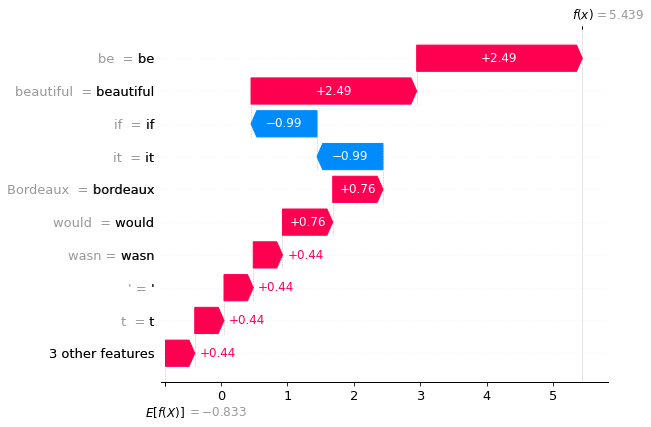

In [41]:
shap.plots.waterfall(shap_values[0, :, "POSITIVE"])

- version modele agnostique

In [53]:
X_train,X_test,Y_train,Y_test = train_test_split(*shap.datasets.iris(), test_size=0.2, random_state=0)
svm = sklearn.svm.SVC(kernel='rbf', probability=True)
svm.fit(X_train, Y_train)
# print the JS visualization code to the notebook
shap.initjs()

# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(X_test)

Using 120 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/30 [00:00<?, ?it/s]

In [55]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")

In [56]:
# plot the SHAP values for the Setosa output of all instances
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

- j'ai utilisé ici la version du dataset fournie par shap (sous forme de dataframe pandas plutot que de numpy array). La version numpy aurait fonctionné, mais sans le nom des features (le nom de colonnes). Utiliser en entrée un dataframe permet d'avoir un graphe immédiatement lisible.
- on utilise ici une méthode d'explication globale, i.e. regardant différents exemples du jeu de donnée

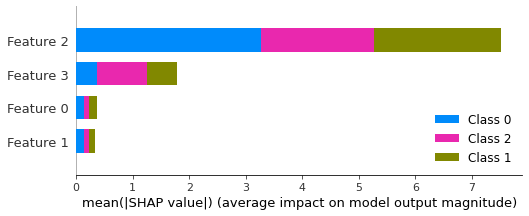

In [57]:
shap.summary_plot(shap_values)

- on découvre que le modèle base sa décision presque uniquement sur la feature 2 !